In [1]:
# Mount drive and unzip as before
from google.colab import drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Comys_Hackathon5.zip"
!unzip -q "{zip_path}" -d /content/


Mounted at /content/drive


In [2]:
import os
import shutil

# Paths to your datasets
train_dir = "/content/Comys_Hackathon5/Task_B/train"
val_dir   = "/content/Comys_Hackathon5/Task_B/val"

# Get list of class folders
train_classes = set(os.listdir(train_dir))
val_classes   = set(os.listdir(val_dir))

# Find missing classes
missing_classes = train_classes - val_classes
print(f"Classes missing in val: {missing_classes}")

# Copy each missing class directory from train to val
for class_name in missing_classes:
    src_class_dir = os.path.join(train_dir, class_name)
    dest_class_dir = os.path.join(val_dir, class_name)

    # Copy entire directory tree
    shutil.copytree(src_class_dir, dest_class_dir)
    print(f"Copied {class_name} to val dataset.")

print("✅ All missing classes copied.")


Classes missing in val: {'Ty_Votaw', 'Ray_Bradbury', '110_frontal', 'Paula_Prentiss', 'Adrian_Fernandez', 'Monica_Seles', 'Rodney_Dangerfield', 'Vicente_Fox_de_la_Concha', '054_frontal', '031_frontal', 'Brian_Schneider', 'Billy_Sollie', 'James_Blake', 'Dave_Odom', 'Milo_Maestrecampo', 'Roger_Clemens', 'Troy_Jenkins', 'Carlos_Ortega', 'Samantha_Daniels', 'Mohammed_Ashraf_Hafiz', 'Anne_Cavers', 'Bryant_Young', 'Jean-Pierre_Bemba', 'Evan_Marriott', 'Jeremy_Shockey', 'Selma_Phoenix', 'Rick_Santorum', 'Cesar_Maia', 'Matt_Siebrandt', 'Michael_Donovan', '047_frontal', 'James_Meredeth', '015_frontal', 'Sergei_Alexandrovitch_Ordzhonikidze', '057_frontal', 'Jose_Lina', 'Eric_Ryan_Donnelly', '062_frontal', 'Compay_Segundo', '119_frontal', 'Larry_Beinfest', '029_frontal', 'Masja_Juel', 'Hugh_Campbell', 'Mike_Helton', 'Stuart_Whitman', 'Yuri_Luzhkov', 'Frank_Schmoekel', 'Bill_Butler', 'Brandon_Boyd', 'Ralf_Schumacher', 'John_Kerr', 'Isabelle_Huppert', 'Annette_Lu', 'Valentino_Rossi', 'Hun_Sen', 'Be

In [3]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.3),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

In [5]:
taskB_train_dir = "/content/Comys_Hackathon5/Task_B/train"
taskB_val_dir   = "/content/Comys_Hackathon5/Task_B/val"


In [6]:
# =======================================
taskB_train_ds = datasets.ImageFolder(taskB_train_dir, transform=transform_train)
taskB_val_ds   = datasets.ImageFolder(taskB_val_dir, transform=transform_val)

taskB_train_loader = DataLoader(taskB_train_ds, batch_size=32, shuffle=True, num_workers=2)
taskB_val_loader   = DataLoader(taskB_val_ds, batch_size=32, shuffle=False, num_workers=2)

num_classes_B = len(taskB_train_ds.classes)
print(f"Number of person identities: {num_classes_B}")

Number of person identities: 877


In [7]:
def create_model(num_classes):
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

model = create_model(num_classes_B)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total

def train_model(model, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader)
        print(f"[{epoch+1}/{num_epochs}] Train Loss: {running_loss/total:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

In [9]:
print("\n🟢 Training Task B: Face Recognition")
train_model(model, taskB_train_loader, taskB_val_loader, num_epochs=40)


🟢 Training Task B: Face Recognition


Epoch 1/40: 100%|██████████| 482/482 [03:03<00:00,  2.62it/s]


[1/40] Train Loss: 5.4958 | Train Acc: 0.1733 | Val Acc: 0.0015


Epoch 2/40: 100%|██████████| 482/482 [02:59<00:00,  2.69it/s]


[2/40] Train Loss: 4.3240 | Train Acc: 0.2876 | Val Acc: 0.0019


Epoch 3/40: 100%|██████████| 482/482 [03:00<00:00,  2.67it/s]


[3/40] Train Loss: 3.4835 | Train Acc: 0.3812 | Val Acc: 0.0017


Epoch 4/40: 100%|██████████| 482/482 [03:03<00:00,  2.62it/s]


[4/40] Train Loss: 2.7512 | Train Acc: 0.5028 | Val Acc: 0.0031


Epoch 5/40: 100%|██████████| 482/482 [03:02<00:00,  2.64it/s]


[5/40] Train Loss: 2.1330 | Train Acc: 0.6399 | Val Acc: 0.0034


Epoch 6/40: 100%|██████████| 482/482 [03:01<00:00,  2.65it/s]


[6/40] Train Loss: 1.6884 | Train Acc: 0.7308 | Val Acc: 0.0031


Epoch 7/40: 100%|██████████| 482/482 [03:00<00:00,  2.67it/s]


[7/40] Train Loss: 1.3610 | Train Acc: 0.7861 | Val Acc: 0.0028


Epoch 8/40: 100%|██████████| 482/482 [03:01<00:00,  2.66it/s]


[8/40] Train Loss: 1.1407 | Train Acc: 0.8119 | Val Acc: 0.0032


Epoch 9/40: 100%|██████████| 482/482 [02:57<00:00,  2.71it/s]


[9/40] Train Loss: 1.0334 | Train Acc: 0.8263 | Val Acc: 0.0028


Epoch 10/40: 100%|██████████| 482/482 [03:00<00:00,  2.66it/s]


[10/40] Train Loss: 0.9227 | Train Acc: 0.8384 | Val Acc: 0.0031


Epoch 11/40: 100%|██████████| 482/482 [02:59<00:00,  2.68it/s]


[11/40] Train Loss: 0.8491 | Train Acc: 0.8480 | Val Acc: 0.0027


Epoch 12/40: 100%|██████████| 482/482 [03:02<00:00,  2.64it/s]


[12/40] Train Loss: 0.7778 | Train Acc: 0.8591 | Val Acc: 0.0032


Epoch 13/40: 100%|██████████| 482/482 [02:59<00:00,  2.68it/s]


[13/40] Train Loss: 0.7268 | Train Acc: 0.8642 | Val Acc: 0.0029


Epoch 14/40: 100%|██████████| 482/482 [02:58<00:00,  2.70it/s]


[14/40] Train Loss: 0.6840 | Train Acc: 0.8712 | Val Acc: 0.0029


Epoch 15/40: 100%|██████████| 482/482 [03:05<00:00,  2.59it/s]


[15/40] Train Loss: 0.6418 | Train Acc: 0.8775 | Val Acc: 0.0028


Epoch 16/40: 100%|██████████| 482/482 [03:02<00:00,  2.65it/s]


[16/40] Train Loss: 0.6239 | Train Acc: 0.8812 | Val Acc: 0.0030


Epoch 17/40: 100%|██████████| 482/482 [02:57<00:00,  2.71it/s]


[17/40] Train Loss: 0.5827 | Train Acc: 0.8884 | Val Acc: 0.0028


Epoch 18/40: 100%|██████████| 482/482 [03:03<00:00,  2.63it/s]


[18/40] Train Loss: 0.5798 | Train Acc: 0.8844 | Val Acc: 0.0027


Epoch 19/40: 100%|██████████| 482/482 [02:59<00:00,  2.69it/s]


[19/40] Train Loss: 0.5425 | Train Acc: 0.8921 | Val Acc: 0.0034


Epoch 20/40: 100%|██████████| 482/482 [03:03<00:00,  2.63it/s]


[20/40] Train Loss: 0.5354 | Train Acc: 0.8908 | Val Acc: 0.0031


Epoch 21/40: 100%|██████████| 482/482 [03:01<00:00,  2.65it/s]


[21/40] Train Loss: 0.5141 | Train Acc: 0.8955 | Val Acc: 0.0033


Epoch 22/40: 100%|██████████| 482/482 [03:01<00:00,  2.66it/s]


[22/40] Train Loss: 0.5000 | Train Acc: 0.8993 | Val Acc: 0.0032


Epoch 23/40: 100%|██████████| 482/482 [03:01<00:00,  2.66it/s]


[23/40] Train Loss: 0.4912 | Train Acc: 0.8993 | Val Acc: 0.0030


Epoch 24/40: 100%|██████████| 482/482 [03:01<00:00,  2.65it/s]


[24/40] Train Loss: 0.4756 | Train Acc: 0.9032 | Val Acc: 0.0036


Epoch 25/40: 100%|██████████| 482/482 [03:01<00:00,  2.65it/s]


[25/40] Train Loss: 0.4662 | Train Acc: 0.9046 | Val Acc: 0.0035


Epoch 26/40: 100%|██████████| 482/482 [03:01<00:00,  2.66it/s]


[26/40] Train Loss: 0.4383 | Train Acc: 0.9080 | Val Acc: 0.0031


Epoch 27/40: 100%|██████████| 482/482 [03:01<00:00,  2.66it/s]


[27/40] Train Loss: 0.4527 | Train Acc: 0.9065 | Val Acc: 0.0034


Epoch 28/40: 100%|██████████| 482/482 [02:58<00:00,  2.70it/s]


[28/40] Train Loss: 0.4433 | Train Acc: 0.9075 | Val Acc: 0.0032


Epoch 29/40: 100%|██████████| 482/482 [03:00<00:00,  2.67it/s]


[29/40] Train Loss: 0.4199 | Train Acc: 0.9117 | Val Acc: 0.0031


Epoch 30/40: 100%|██████████| 482/482 [03:03<00:00,  2.63it/s]


[30/40] Train Loss: 0.4007 | Train Acc: 0.9150 | Val Acc: 0.0034


Epoch 31/40: 100%|██████████| 482/482 [02:59<00:00,  2.68it/s]


[31/40] Train Loss: 0.4113 | Train Acc: 0.9123 | Val Acc: 0.0031


Epoch 32/40: 100%|██████████| 482/482 [03:03<00:00,  2.63it/s]


[32/40] Train Loss: 0.3853 | Train Acc: 0.9171 | Val Acc: 0.0033


Epoch 33/40: 100%|██████████| 482/482 [03:05<00:00,  2.60it/s]


[33/40] Train Loss: 0.3892 | Train Acc: 0.9165 | Val Acc: 0.0030


Epoch 34/40: 100%|██████████| 482/482 [03:02<00:00,  2.65it/s]


[34/40] Train Loss: 0.3994 | Train Acc: 0.9133 | Val Acc: 0.0029


Epoch 35/40: 100%|██████████| 482/482 [02:58<00:00,  2.71it/s]


[35/40] Train Loss: 0.3825 | Train Acc: 0.9192 | Val Acc: 0.0033


Epoch 36/40: 100%|██████████| 482/482 [02:59<00:00,  2.68it/s]


[36/40] Train Loss: 0.3731 | Train Acc: 0.9190 | Val Acc: 0.0033


Epoch 37/40: 100%|██████████| 482/482 [02:59<00:00,  2.69it/s]


[37/40] Train Loss: 0.3721 | Train Acc: 0.9191 | Val Acc: 0.0031


Epoch 38/40: 100%|██████████| 482/482 [03:00<00:00,  2.67it/s]


[38/40] Train Loss: 0.3724 | Train Acc: 0.9202 | Val Acc: 0.0026


Epoch 39/40: 100%|██████████| 482/482 [02:56<00:00,  2.72it/s]


[39/40] Train Loss: 0.3405 | Train Acc: 0.9282 | Val Acc: 0.0034


Epoch 40/40: 100%|██████████| 482/482 [02:59<00:00,  2.69it/s]


[40/40] Train Loss: 0.3480 | Train Acc: 0.9262 | Val Acc: 0.0029


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.78      0.88      0.82         8
           2       1.00      1.00      1.00         8
           3       0.67      1.00      0.80         8
           4       1.00      1.00      1.00         8
           5       0.73      1.00      0.84         8
           6       1.00      1.00      1.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         8
          17       0.00    

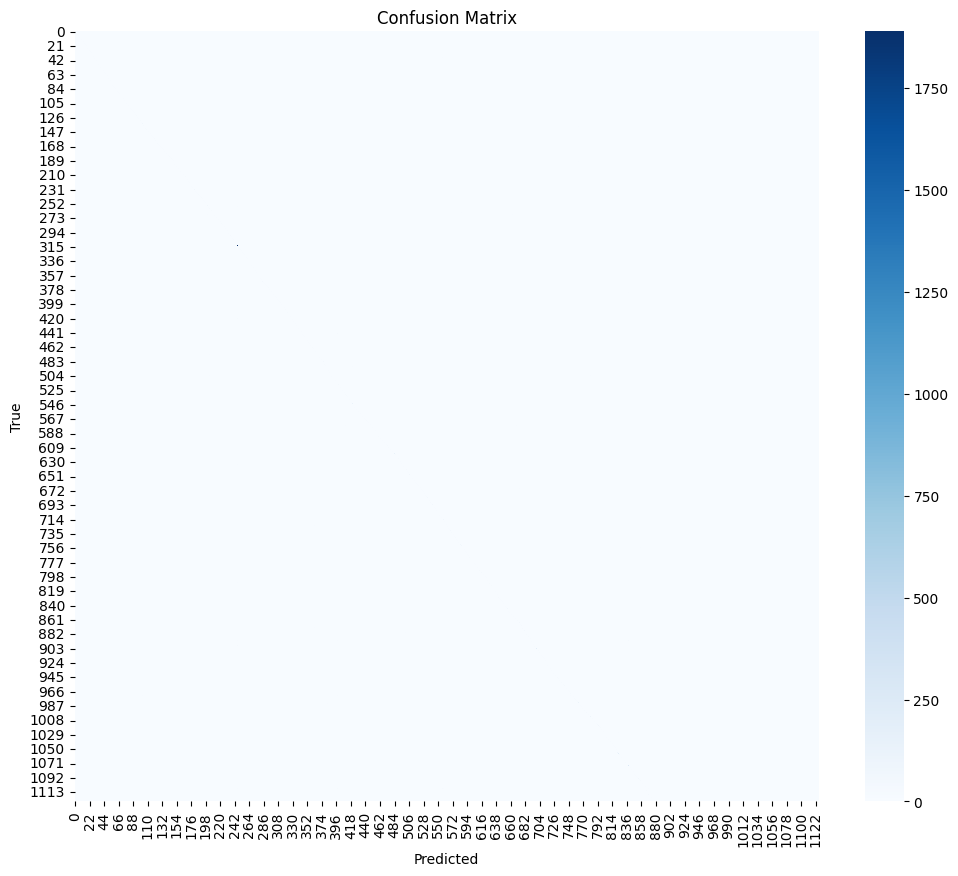

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_f1_confusion(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report using integer labels
    print(classification_report(all_labels, all_preds, zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# ✅ Now call
evaluate_f1_confusion(model, taskB_val_loader)


In [11]:
from sklearn.metrics import f1_score

def compute_macro_f1(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Macro-averaged F1-Score: {macro_f1:.4f}")

compute_macro_f1(model, taskB_val_loader)


Macro-averaged F1-Score: 0.0057


In [12]:
from sklearn.metrics import f1_score

def compute_macro_f1(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Macro-averaged F1-Score: {macro_f1:.4f}")

compute_macro_f1(model, taskB_val_loader)


Macro-averaged F1-Score: 0.0057


In [13]:
val_acc = evaluate_model(model, taskB_val_loader)
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.0029


Saving John_Nash_0001.jpg to John_Nash_0001 (1).jpg
🔝 Top 3 predictions:
Bob_Geldof: 0.1514
Samuel_Waksal: 0.1344
Sergio_Vieira_De_Mello: 0.1020


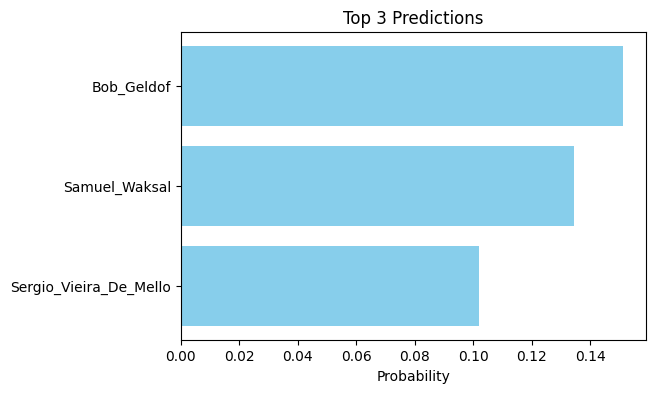

In [17]:
from google.colab import files
uploaded = files.upload()
# Assuming you already have:
# - probs: softmax probabilities from the model
# - top3_idx: indices of top 3 predictions
# - top3_probs: probabilities of top 3
# - top3_names: class names of top 3

# Print top 3 predictions
print("🔝 Top 3 predictions:")
for i in range(3):
    print(f"{top3_names[i]}: {top3_probs[i]:.4f}")

# Plot probabilities as bar chart
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
y_pos = np.arange(len(top3_names))
plt.barh(y_pos, top3_probs, align='center', color='skyblue')
plt.yticks(y_pos, top3_names)
plt.gca().invert_yaxis()  # highest on top
plt.xlabel('Probability')
plt.title('Top 3 Predictions')
plt.show()


In [18]:
# Save the model weights after training
torch.save(model.state_dict(), "taskB_model.pth")
print("✅ Model saved as taskB_model.pth")


✅ Model saved as taskB_model.pth


In [19]:
from google.colab import files
files.download("taskB_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>